In [53]:
import yaml
import pandas as pd
import numpy as np
import re
from bokeh.plotting import output_notebook, figure
import seaborn as sns
import matplotlib.pyplot as plt

output_notebook()

Loading BokehJS ...

## 2. Data acquisition

The data used in this project is obtained from two different data sources. The BMI data is obtained from https://www.ncdrisc.org/data-downloads-adiposity.html and downloaded in the csv format. This data contains out of all of the mean BMI's (with 95% confidence intervals) per country per sex, ranging from the year 1975 to 2016. In addition, the dataset contains the prevalence of certain BMI ranges (with 95% confidence intervals). For example, a person is classified as obese if the BMI is higher or equal to 30.

The affordability of a healthy diet is obtained from https://databank.worldbank.org/source/food-prices-for-nutrition (select all under country, select 'Affordability of a healthy diet: ratio of cost to food expenditures' under series, select 2017 under year) and downloaded in the csv format. In this dataset the affordability of a healthy diet is defined as the ratio of the cost of a healthy diet to food expenditures. This ratio is given by country and by sex in the year 2017.

Keep in mind that the BMI dataset is from the year 2017 and the healthy diet affordability dataset is from 2016. At this point in time the global BMI data is only available up to 2016 and the healthy diet data from 2017 until 2020. In this project the 2017 and 2016 will be compared. The mean BMI and heatlhy diet affordability are unlikely to change a lot from year to year and therefor are compared. However, when 2017 BMI data is available it is better to use that instead of the 2016 data.

## 3. Loading the data

The dataset are loaded into a pandas dataframe using a config file

In [54]:
# load the datafiles using a config files
with open("./config.yaml", 'r') as stream:
    config = yaml.safe_load(stream)

bmi = config['bmi']
healthy_diet_affordability = config['food_affordability']

### 3.1 BMI

In [55]:
df_bmi = pd.read_csv(bmi, encoding='latin-1') # file uses latin-1 encoding
df_bmi = df_bmi.astype({'Country/Region/World': str, 'ISO': str})
df_bmi = df_bmi[df_bmi.Year == 2016]  # we only want the 2016 data
df_bmi = df_bmi.drop(columns='Year')  # remove the year column, we only have 2016 left so redundant
df_bmi.head()
df_bmi.dtypes

Country/Region/World                                                         object
ISO                                                                          object
Sex                                                                          object
Mean BMI                                                                    float64
Mean BMI lower 95% uncertainty interval                                     float64
Mean BMI upper 95% uncertainty interval                                     float64
Prevalence of BMI>=30 kg/m² (obesity)                                       float64
Prevalence of BMI>=30 kg/m² lower 95% uncertainty interval                  float64
Prevalence of BMI>=30 kg/m² upper 95% uncertainty interval                  float64
Prevalence of BMI>=35 kg/m² (severe obesity)                                float64
Prevalence of BMI>=35 kg/m² lower 95% uncertainty interval                  float64
Prevalence of BMI>=35 kg/m² upper 95% uncertainty interval                  

Some column names are pretty long and make it inconvenient to read and work with. The next code chunk shortens these column names to make it more readible. This is done by regex and substituting some words into shorter words or removing parts of the column name.

In [56]:
# dict for patterns and replacements for the column names
replace_dict = {'Prevalence': 'Prev', 'kg/m²': '', 'lower 95% uncertainty interval': 'lower', 'upper 95% uncertainty interval': 'upper'}
for pattern, replacement in replace_dict.items():
    df_bmi = df_bmi.rename(columns=lambda column: re.sub(pattern, replacement, column))  # loops trhough all of the columns and use re.sub for the replacement
    

In [57]:
df_bmi.head()

,Country/Region/World,ISO,Sex,Mean BMI,Mean BMI lower,Mean BMI upper,Prev of BMI>=30 (obesity),Prev of BMI>=30 lower,Prev of BMI>=30 upper,Prev of BMI>=35 (severe obesity),...,Prev of BMI 25 to <30 upper,Prev of BMI 30 to <35,Prev of BMI 30 to <35 lower,Prev of BMI 30 to <35 upper,Prev of BMI 35 to <40,Prev of BMI 35 to <40 lower,Prev of BMI 35 to <40 upper,Prev of BMI >=40 (morbid obesity),Prev of BMI >=40 lower,Prev of BMI >=40 upper
41,Afghanistan,AFG,Men,22.682456,20.157475,25.241857,0.033603,0.013884,0.066334,0.003314,...,0.242503,0.030290,0.011207,0.062681,0.002271,0.000310,0.007487,0.001043,0.000074,0.004265
83,Albania,ALB,Men,27.174471,25.975170,28.338256,0.223735,0.153334,0.300834,0.045036,...,0.515957,0.178699,0.113401,0.252200,0.037684,0.013616,0.076984,0.007352,0.001180,0.021953
125,Algeria,DZA,Men,24.865386,23.487321,26.220294,0.206662,0.141854,0.279979,0.042840,...,0.463570,0.163822,0.102610,0.234048,0.031750,0.011066,0.065164,0.011090,0.002289,0.029802
167,American Samoa,ASM,Men,33.066721,31.338678,34.662447,0.587546,0.502606,0.666355,0.322678,...,0.370043,0.264868,0.191211,0.340031,0.183871,0.109862,0.263723,0.138807,0.067651,0.223666
209,Andorra,AND,Men,27.478395,24.988831,30.001977,0.267498,0.186223,0.354723,0.068565,...,0.532478,0.198934,0.125035,0.280761,0.052701,0.017627,0.109639,0.015864,0.002652,0.046309


### 3.2 Affordability of a healthy diet

In [58]:
df_healthy_diet = pd.read_csv(healthy_diet_affordability, encoding='latin-1', skipfooter=5, engine='python')  # skip last lines, does not contain data
df_healthy_diet.drop(columns=['Classification Name', 'Classification Code', 'Time', 'Time Code'], inplace=True)  # irrelevant columns
df_healthy_diet.rename(columns={'Affordability of a healthy diet: ratio of cost to food expenditures [CoHD_fexp]': 'Affordability of a healthy diet'}, inplace=True)
df_healthy_diet['Affordability of a healthy diet'] = df_healthy_diet['Affordability of a healthy diet'].replace('..', np.nan)
df_healthy_diet = df_healthy_diet.astype({'Affordability of a healthy diet': float})

In [59]:
df_healthy_diet.head()
df_healthy_diet.dtypes

Country Name                        object
Country Code                        object
Affordability of a healthy diet    float64
dtype: object

## 4. Data exploration

Before the data exploration a decision must be made wether or not the data should be merged already. This is done by seeing if there are differences in countries used in the datasets. The reasoning behind this is that he country variable the variable is on which the datasets are merged. If some countries are not shared between the datasets, the data will be omitted.

In [60]:
countries_bmi = df_bmi['ISO'].unique()
countries_healthy_diet = df_healthy_diet['Country Code'].unique()
countries_not_in_common = set(countries_bmi) ^ set(countries_healthy_diet)  # check which values are not shared
print(countries_not_in_common)
print(len(countries_not_in_common))

{'KIR', 'LBN', 'MHL', 'WLD', 'VEN', 'TCA', 'PRK', 'HIC', 'SAS', 'VUT', 'ERI', 'SSF', 'CYM', 'UZB', 'PNG', 'PLW', 'VGB', 'NIU', 'SLB', 'NAC', 'AIA', 'YEM', 'MSR', 'TKL', 'TUV', 'LCN', 'SOM', 'ECS', 'FSM', 'TKM', 'COK', 'TLS', 'GTM', 'CUB', 'ABW', 'AND', 'WSM', 'GEO', 'TON', 'LMC', 'UMC', 'GRL', 'LBY', 'BON', 'AFG', 'MEA', 'PYF', 'NRU', 'SYR', 'CUW', 'ASM', 'EAS', 'UKR', 'LIC', 'SXM', 'PRI'}
56


As can be seen above there are a lot of countries (56) which are not in common between both datasets. When merging these datasets (using inner merge) this data gets lost. Therefore it makes sense to merge the datasets before data exploration, because otherwise data exploration is done on data which is later omitted.

In [61]:
df_merged = df_healthy_diet.merge(right=df_bmi, 
                                  left_on='Country Code',
                                  right_on='ISO',
                                  how='inner')
df_merged.drop(columns=['Country/Region/World', 'ISO'], inplace=True)  # duplicate columns that can be deleted
df_merged.head()

,Country Name,Country Code,Affordability of a healthy diet,Sex,Mean BMI,Mean BMI lower,Mean BMI upper,Prev of BMI>=30 (obesity),Prev of BMI>=30 lower,Prev of BMI>=30 upper,...,Prev of BMI 25 to <30 upper,Prev of BMI 30 to <35,Prev of BMI 30 to <35 lower,Prev of BMI 30 to <35 upper,Prev of BMI 35 to <40,Prev of BMI 35 to <40 lower,Prev of BMI 35 to <40 upper,Prev of BMI >=40 (morbid obesity),Prev of BMI >=40 lower,Prev of BMI >=40 upper
0,Albania,ALB,0.425,Men,27.174471,25.975170,28.338256,0.223735,0.153334,0.300834,...,0.515957,0.178699,0.113401,0.252200,0.037684,0.013616,0.076984,0.007352,0.001180,0.021953
1,Albania,ALB,0.425,Women,26.507512,25.196840,27.859854,0.227215,0.160322,0.300595,...,0.365555,0.154878,0.096033,0.225306,0.054146,0.022398,0.100402,0.018191,0.004656,0.044692
2,Algeria,DZA,0.605,Men,24.865386,23.487321,26.220294,0.206662,0.141854,0.279979,...,0.463570,0.163822,0.102610,0.234048,0.031750,0.011066,0.065164,0.011090,0.002289,0.029802
3,Algeria,DZA,0.605,Women,26.561166,25.080506,28.031641,0.362187,0.287831,0.440170,...,0.383587,0.225826,0.155871,0.303311,0.093082,0.047469,0.152826,0.043279,0.015501,0.089878
4,Angola,AGO,0.972,Men,22.436538,19.732903,25.172488,0.042276,0.016349,0.081935,...,0.237444,0.035127,0.011140,0.073699,0.005868,0.000739,0.018757,0.001281,0.000033,0.006267


The datasets are now merged. In the following sections general data exploration, BMI data exploration and Affordability of a healthy diet data exploration are performed.

### 4.1 General

In [62]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330 entries, 0 to 329
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Country Name                       330 non-null    object 
 1   Country Code                       330 non-null    object 
 2   Affordability of a healthy diet    322 non-null    float64
 3   Sex                                330 non-null    object 
 4   Mean BMI                           330 non-null    float64
 5   Mean BMI lower                     330 non-null    float64
 6   Mean BMI upper                     330 non-null    float64
 7   Prev of BMI>=30  (obesity)         330 non-null    float64
 8   Prev of BMI>=30  lower             330 non-null    float64
 9   Prev of BMI>=30  upper             330 non-null    float64
 10  Prev of BMI>=35  (severe obesity)  330 non-null    float64
 11  Prev of BMI>=35  lower             330 non-null    float64

We have 330 entries left after merging. If correct, each country should have BMI data about both sexes. So data of a total of $330 / 2 = 165$  countries is remaining. This is checked in the following code chunk 

In [63]:
df_merged['Country Name'].nunique()

165

This confirms that the dataset indeed holds data of 165 countries.

### 4.2 BMI

In [64]:
df_merged['Mean BMI'].describe()

count    330.000000
mean      25.722590
std        2.288288
min       20.110440
25%       23.834583
50%       26.069640
75%       27.302251
max       31.697884
Name: Mean BMI, dtype: float64

As can be seen the mean BMI in the world using the available data is approximately 25.7. At a BMI higher or equal to 25 a person is classified as 'overweight'. This means that the mean of the population is overweight. Another interesting value is the max value, which is 31.697884. This means that this country has a mean BMI of above 30 of a certain gender. A BMI above 30 is classified as obese and therefor that country's mean population is obese.

In [65]:
df_merged[df_merged['Mean BMI'] == df_merged['Mean BMI'].max()]

,Country Name,Country Code,Affordability of a healthy diet,Sex,Mean BMI,Mean BMI lower,Mean BMI upper,Prev of BMI>=30 (obesity),Prev of BMI>=30 lower,Prev of BMI>=30 upper,...,Prev of BMI 25 to <30 upper,Prev of BMI 30 to <35,Prev of BMI 30 to <35 lower,Prev of BMI 30 to <35 upper,Prev of BMI 35 to <40,Prev of BMI 35 to <40 lower,Prev of BMI 35 to <40 upper,Prev of BMI >=40 (morbid obesity),Prev of BMI >=40 lower,Prev of BMI >=40 upper
99,"Egypt, Arab Rep.",EGY,0.286,Women,31.697884,31.087575,32.298419,0.424822,0.358833,0.489959,...,0.344519,0.231362,0.171594,0.292669,0.119325,0.075895,0.171071,0.074135,0.039651,0.121336


The mean female population in egypt is obese

In [66]:
df_merged[df_merged['Mean BMI'] == df_merged['Mean BMI'].min()]

,Country Name,Country Code,Affordability of a healthy diet,Sex,Mean BMI,Mean BMI lower,Mean BMI upper,Prev of BMI>=30 (obesity),Prev of BMI>=30 lower,Prev of BMI>=30 upper,...,Prev of BMI 25 to <30 upper,Prev of BMI 30 to <35,Prev of BMI 30 to <35 lower,Prev of BMI 30 to <35 upper,Prev of BMI 35 to <40,Prev of BMI 35 to <40 lower,Prev of BMI 35 to <40 upper,Prev of BMI >=40 (morbid obesity),Prev of BMI >=40 lower,Prev of BMI >=40 upper
108,Ethiopia,ETH,2.188,Men,20.11044,19.095816,21.098157,0.019809,0.008283,0.038256,...,0.174245,0.017769,0.00642,0.036051,0.001434,0.000262,0.004244,0.000605,0.000063,0.002157


Ethiopia has the lowest BMI in the world (using the available data). This makes sense because there is a lot undernourishment and hunger in that country.

TypeError: 'Text' object is not callable

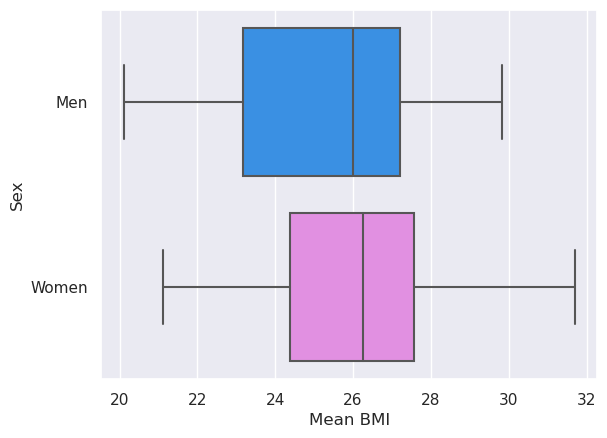

In [95]:
sns.set(style="darkgrid")
bmi_boxplot = sns.boxplot(x='Mean BMI', y='Sex', data=df_merged,
                          palette={'Men': 'dodgerblue', 'Women': 'violet'})
bmi_boxplot.title('Boxplot of mean BMI per sex')
plt.show(bmi_boxplot)

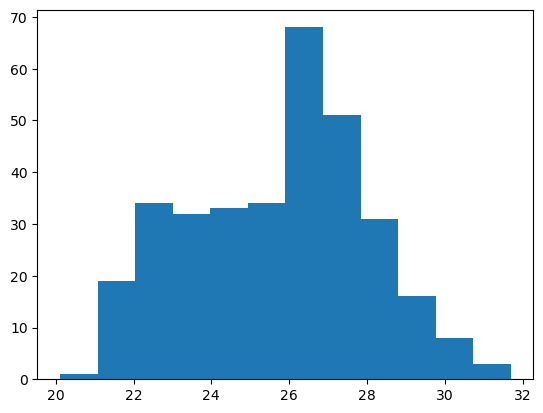

In [79]:
plt.hist(df_merged['Mean BMI'], bins='auto')
plt.show()

### Affordability of a healthy diet